# Arrange complete dataset

In [1]:
import os
import numpy as np
import torch
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from joblib import dump, load

from time import sleep
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier


from bring_features_and_file_paths import bring_features_and_file_paths
from bring_features_and_file_paths import from_spectrogram_path_to_BirdNET_output_path
from bring_features_and_file_paths import get_spectrogram_time_mark_in_file
from bring_features_and_file_paths import get_BirdNET_detections
from bring_features_and_file_paths import transform_features

## Bring all the features and file paths

In [2]:
features_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/features_second_pass'
indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_first_pass/exclude_indices.pth'
dim_red_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/clusters_second_pass_big_100/dim_red_model'
scale_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/clusters_second_pass_big_100/scale_model'
clusters_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/clusters_second_pass_big_100/clusters.npy'

In [3]:
features, file_paths = bring_features_and_file_paths(features_path)

exclude_indices = set(torch.load(indices_path))
include_indices = [idx for idx in range(len(features)) if idx not in exclude_indices]
features = features[include_indices]
file_paths = file_paths[include_indices]

We have 2136286 feature vectors.


Now, we want to transform the features, scaling them and reducing their dimensionality

In [4]:
dim_red_model = load(dim_red_path)
scale_model = load(scale_path)

In [5]:
samples = transform_features(features, scale_model, dim_red_model)
samples.shape

(1978138, 2)

Load the clusters generated from the features

We will use them to classify our sample of features now

In [6]:
clusters = np.load(clusters_path, allow_pickle=True)
vectors=clusters[()]['x']
labels=clusters[()]['y']
print(vectors.shape)
print(labels.shape)

(395627, 2)
(395627,)


In [7]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 100
Estimated number of noise points: 0


In [8]:
def choose_random_rows(an_array, n_samples):
    number_of_rows = an_array.shape[0]
    random_indices = np.random.choice(number_of_rows, size=n_samples, replace=False)
    random_rows = an_array[random_indices, :]
    return random_rows

X = choose_random_rows(vectors,150000)
n_components=X.shape[1]

Train a k-nearest neighbor algorithm to predict the samples

In [9]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(vectors, labels)

KNeighborsClassifier(n_neighbors=10)

In [10]:
label_predictions=neigh.predict(samples)
core_samples = np.zeros_like(label_predictions, dtype=bool)
core_samples[label_predictions != -1] = True
n_noise_points = list(label_predictions).count(-1)

[]

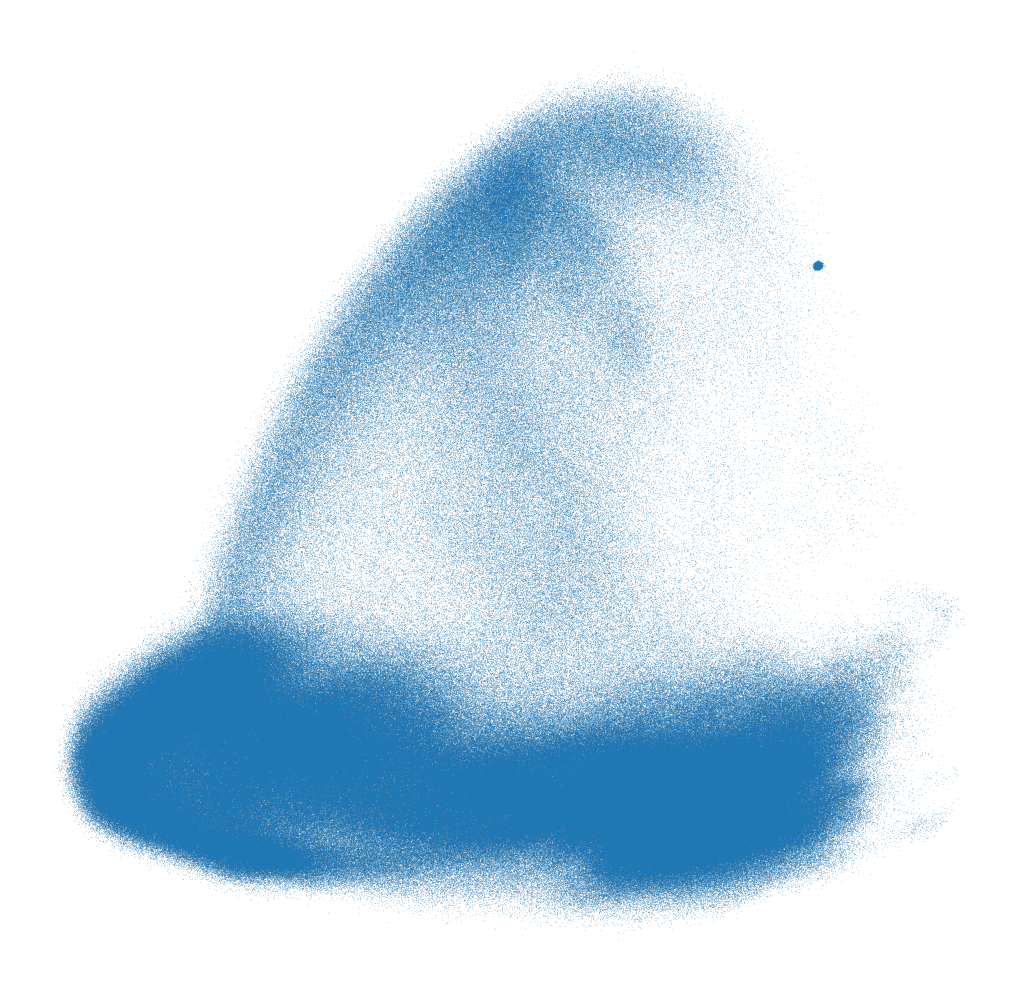

In [11]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot()
#ax.scatter(vectors[:,0],vectors[:,1], 0.01)
ax.scatter(samples[:,0],
           samples[:,1],
           s=0.006
          )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

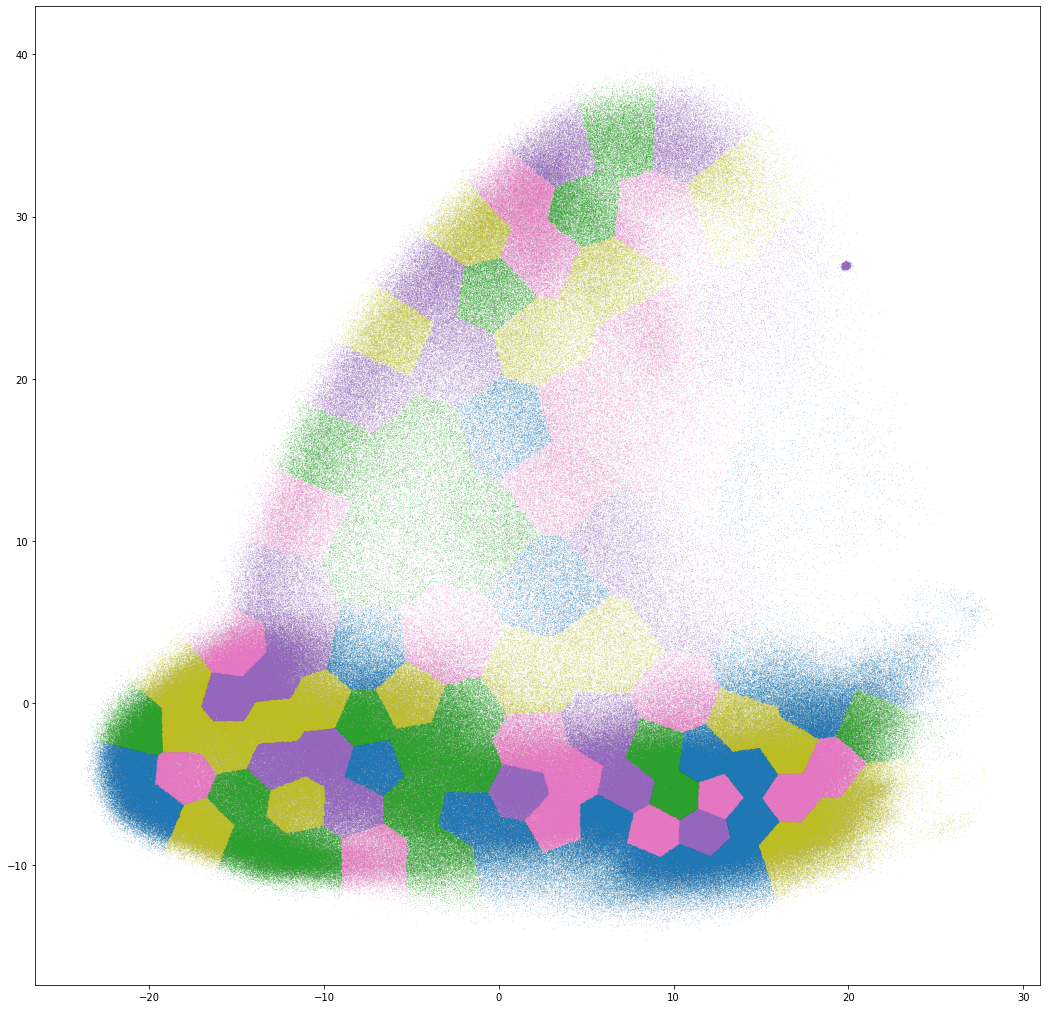

In [12]:
# Black removed and is used for noise instead.
print_outliers=True
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = label_predictions == k
    #class_member_mask = labels == k
    xy = samples[class_member_mask & core_samples]
    ax.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        #markeredgecolor="k",
        markersize=0.06,
    )

    if print_outliers:
        xy = samples[class_member_mask & ~core_samples]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

In [13]:
dpath='/projects/MultiActiveAI/Samir_VICReg_Outputs/Complete_Data_100'
# dpath='/grand/projects/BirdAudio/Soundscapes/Complete_Data/'
if os.path.isfile(os.path.join(dpath, 'Data.csv')):
    print('Data already exists, loading it...')
    data = pd.read_csv(os.path.join(dpath, 'Data.csv'))
    print('Done!')
else:
    print('Data does not exist, building it...')
    BirdNET_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/BirdNET_Output'
    Spectrograms_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/Second_Filtered_Spectrograms'
    spectrogram_duration = 9.0
    data = []
    for k, fpath in enumerate(tqdm(file_paths)):
        file_path = ''.join([chr(int(x)) for x in fpath]).replace('~','')
        BirdNET_PATH = from_spectrogram_path_to_BirdNET_output_path(fpath)
        try:
            start_time = get_spectrogram_time_mark_in_file(fpath, spectrogram_duration)
            #print(file_path)

            interval = (start_time, start_time + spectrogram_duration)
            data_elements = get_BirdNET_detections(os.path.join(BirdNET_BASE_PATH, BirdNET_PATH), interval, confidence_threshold = 0.0)
            for data_element in data_elements:
                data_element['paths']=file_path
                data_element['x']=samples[k,0]
                data_element['y']=samples[k,1]
                data_element['device']=int(data_element['device'])
                data_element['labels']=label_predictions[k]
                data.append(data_element)

        except:
            print("Something was wrong with")
            print(file_path)

#         if k > 1000:
#             break

    print('Done!')

    data = pd.DataFrame(data=data)
    print('Saving it in ' + data + ' ...')
    data.to_csv(os.path.join(dpath, 'Data.csv'))
    print('Done!')

data

Data does not exist, building it...


 60%|█████▉    | 1183935/1978138 [48:12<26:29, 499.80it/s]  

Something was wrong with
                                                                                 


 62%|██████▏   | 1228086/1978138 [49:31<14:24, 867.77it/s] 

Something was wrong with
                                                                                 


100%|██████████| 1978138/1978138 [1:19:33<00:00, 414.41it/s] 


Done!


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U13'), dtype('float64')) -> None

In [31]:
len(file_paths)

1978138

In [16]:
data.to_csv(os.path.join(dpath, 'Data.csv'))

In [17]:
# dpath='/grand/projects/BirdAudio/Soundscapes/Complete_Data/'
dpath='/projects/MultiActiveAI/Samir_VICReg_Outputs/Complete_Data_100'
data = pd.read_csv(os.path.join(dpath, 'Data.csv'))

[]

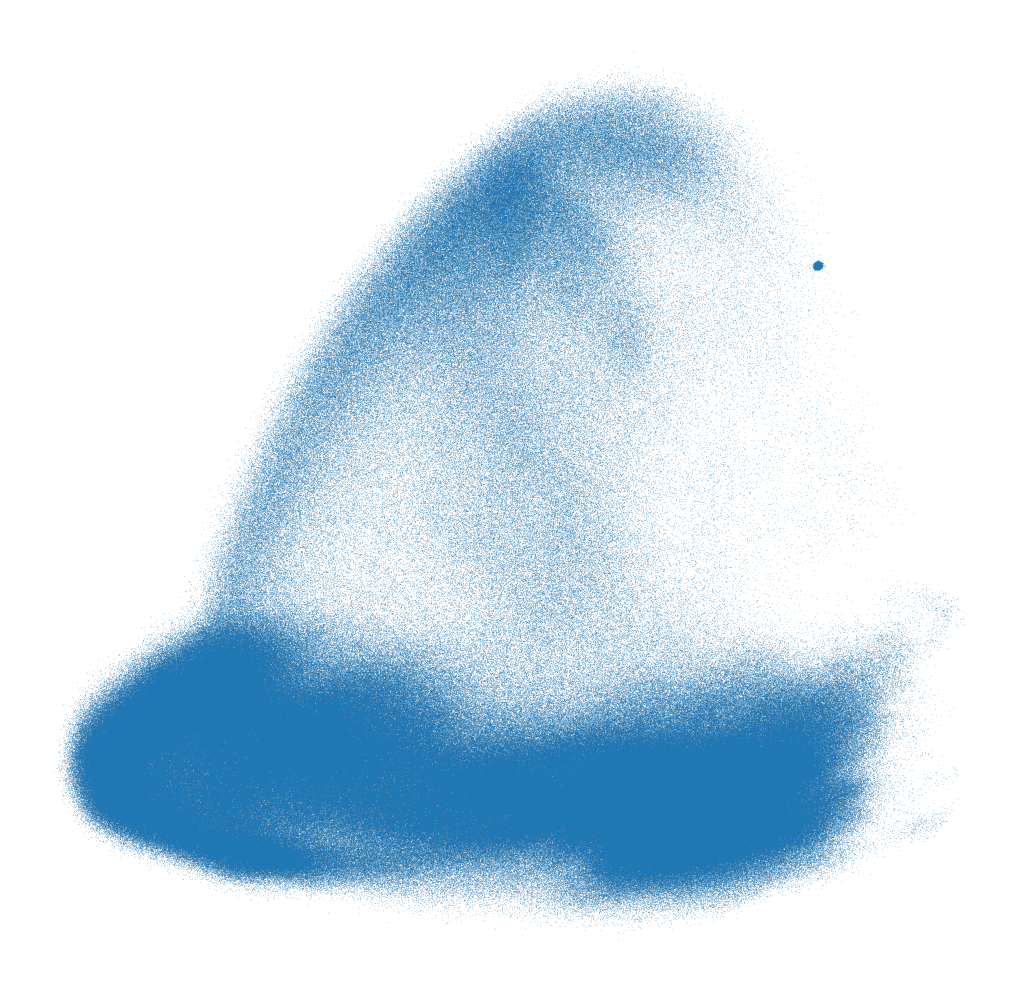

In [19]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot()
#ax.scatter(vectors[:,0],vectors[:,1], 0.01)
ax.scatter(samples[:,0],
           samples[:,1],
           s=0.006,
#            c=data['hour']
          )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

In [27]:
len(data)

2458141

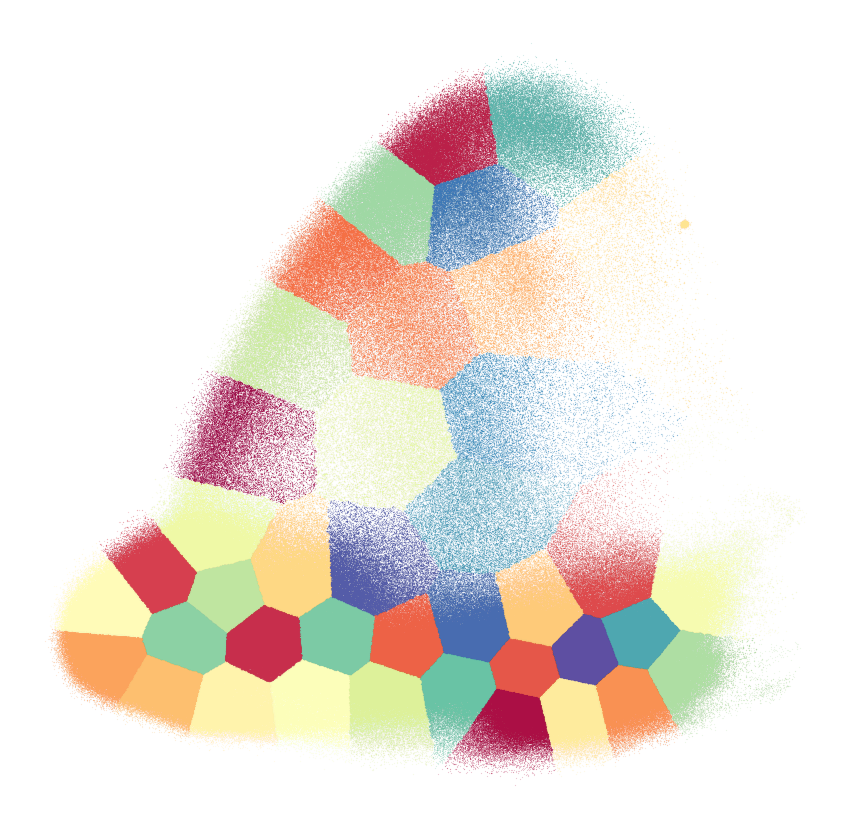

In [45]:
column = 'labels'
labels = data[column]
f_embedded = np.transpose(np.array([data['x'], data['y']]))
unique_labels = sorted(set(labels))

cmap = plt.cm.get_cmap("twilight_shifted" if column == 'hour' else 'Spectral')
colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[labels != -1] = True
n_noise_points = list(labels).count(-1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for k, col in zip(unique_labels, colors):
    detection_mask = (data['detection'] != "No detection") & (data['confidence'] > 0.9)
    class_member_mask = labels == k
    
    # This mask can be used to ignore particular devices.
    device_mask = ~data['device'].isin([4879, 23764])
    
    xy = f_embedded[class_member_mask & core_samples_mask]
#     ax.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor=col,
#         markersize=1,
#     )
    
    ax.scatter(xy[:,0],
           xy[:,1],
           s=0.006,
           color=col
          )
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

fig.set_size_inches(15, 15)
# plt.savefig(f"tsne_{column}.png", dpi=300)

# # Save legend separately
# fig, ax = plt.subplots()
# if column == "hour":
#     pass

# elif column != 'labels':
#     patches = [mpatches.Patch(color=col, label=k) for k, col in zip(unique_labels, colors)]
#     if column == "month":
#         ncol = len(patches)
#     elif column == "week":
#         ncol = len(patches) // 3
#     elif column == "location":
#         ncol = len(patches) // 2
#     elif column == "device":
#         ncol = len(patches) // 2
#     ax.legend(handles=patches, fontsize=28, ncol=ncol)
#     plt.gca().set_axis_off()
#     plt.savefig(f"tsne_legend_{column}.png", bbox_inches='tight')